# Analyzing Categorical Data from the General Social Survey in Python

Welcome to your webinar workspace! In this session, we will introduce you to categorical variables in Python. We will be using a subset of data from the [General Social Survey](https://www.kaggle.com/datasets/norc/general-social-survey?select=gss.csv).

The following code block imports some of the main packages we will be using, which are [pandas](https://pandas.pydata.org/docs/index.html), [NumPy](https://numpy.org/doc/stable/index.html), and [Plotly](https://plotly.com/graphing-libraries/). We will also use [statsmodels](https://www.statsmodels.org/dev/index.html) for a special type of categorical plot.

We will read in our data and preview it as an interactive table. Please follow along with the code and feel free to ask any questions!

In [2]:
# Import packages
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Read in csv as a DataFrame and preview it
df = pd.read_csv("gss_sub.csv")
df

year      id  ... inequality household_size
0      1972.0     1.0  ...        NaN            1.0
1      1972.0     2.0  ...        NaN            2.0
2      1972.0     3.0  ...        NaN            4.0
3      1972.0     4.0  ...        NaN            2.0
4      1972.0     5.0  ...        NaN            2.0
...       ...     ...  ...        ...            ...
59594  2014.0  2539.0  ...        NaN            1.0
59595  2014.0  2540.0  ...        NaN            1.0
59596  2014.0  2541.0  ...        NaN            3.0
59597  2014.0  2542.0  ...        NaN            2.0
59598  2014.0  2543.0  ...        NaN            1.0

[59599 rows x 16 columns]

## Inspecting our data
### What types of data are in our dataset?
One of the simplest ways to get an overview of the types of data you are working with is to use the [`.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) method, which will return a summary of your data, including:
- The column names.
- The number of non-null values per column.
- The data types.
- The memory usage of the DataFrame.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59599 entries, 0 to 59598
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   59599 non-null  float64
 1   id                     59599 non-null  float64
 2   labor_status           59583 non-null  object 
 3   self_employed          59306 non-null  object 
 4   marital_status         59575 non-null  object 
 5   n_siblings             56682 non-null  float64
 6   age                    59599 non-null  float64
 7   high_school            59440 non-null  float64
 8   degree                 59464 non-null  object 
 9   political_affiliation  59257 non-null  object 
 10  environment            59388 non-null  object 
 11  law_enforcement        59378 non-null  object 
 12  drugs                  59380 non-null  object 
 13  space_exploration      59596 non-null  object 
 14  inequality             1532 non-null   float64
 15  ho

Above we see that our DataFrame contains `float64` column (numerical data), as well as a number of `object` columns. Object data types contain strings.

### Inspecting individual columns
To inspect a categorical column, use the [`.describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) method with the `include` parameter to select a particular DataType (in this case `"O"`). This returns the count, number of unique values, the mode, and frequency of the mode.

In [4]:
df.describe(include="O")

labor_status self_employed  ...  drugs space_exploration
count              59583         59306  ...  59380             59596
unique                 8             4  ...      5                 5
top     WORKING FULLTIME  SOMEONE ELSE  ...    IAP               IAP
freq               29437         49497  ...  38143             59115

[4 rows x 9 columns]

The [`.value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) method can give you a greater insight into the distribution and structure of a column.

In [5]:
df["environment"].value_counts()

IAP            38143
TOO LITTLE     13183
ABOUT RIGHT     5445
TOO MUCH        1698
DK               919
Name: environment, dtype: int64

## Manipulating categorical data
### Let's convert our object columns to categories
- The categorical variable type can be useful, especially here:
    - Save on memory when there are only a few different values.
    - You can specify a precise order to the categories when the default order may be incorrect (e.g., via alphabetical).
    - Can be compatible with other Python libraries.

Let's take our existing categorical variables and convert them from strings to categories. Here, we use [`.select_dtypes()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html) to return only object columns, and with a dictionary set their type to be a category.

In [6]:
# Create a dictionary of column and data type mappings
conversion_dict = {k: "category" for k in df.select_dtypes(include="object").columns}

# Convert our DataFrame and check the data types
df = df.astype(conversion_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59599 entries, 0 to 59598
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   year                   59599 non-null  float64 
 1   id                     59599 non-null  float64 
 2   labor_status           59583 non-null  category
 3   self_employed          59306 non-null  category
 4   marital_status         59575 non-null  category
 5   n_siblings             56682 non-null  float64 
 6   age                    59599 non-null  float64 
 7   high_school            59440 non-null  float64 
 8   degree                 59464 non-null  category
 9   political_affiliation  59257 non-null  category
 10  environment            59388 non-null  category
 11  law_enforcement        59378 non-null  category
 12  drugs                  59380 non-null  category
 13  space_exploration      59596 non-null  category
 14  inequality             1532 non-null  

Already we can see that the memory usage of the DataFrame has been halved from 7 mb to 4 mb! This can help when working with large quantities of data, such as this survey that we'll be working with.

### Cleaning up the `labor_status` column
To analyze the relationship between employment and attitudes over time, we need to clean up the `labor_status` column. We can preview the existing categories using `.categories`.

In [7]:
df["labor_status"].cat.categories

Index(['KEEPING HOUSE', 'OTHER', 'RETIRED', 'SCHOOL', 'TEMP NOT WORKING',
       'UNEMPL, LAID OFF', 'WORKING FULLTIME', 'WORKING PARTTIME'],
      dtype='object')

Let's collapse some of these categories. The easiest way to do this is to replace the values inside the column using a dictionary, and then reset the data type back to a category.

In [8]:
# Create a dictionary of categories to collapse
new_labor_status = {"UNEMPL, LAID OFF": "UNEMPLOYED", 
                    "TEMP NOT WORKING": "UNEMPLOYED",
                    "WORKING FULLTIME": "EMPLOYED",
                    "WORKING PARTTIME": "EMPLOYED"
                   }

# Replace the values in the column and reset as a category
df["labor_status_clean"] = df["labor_status"].replace(new_labor_status).astype("category")

# Preview the new column
df["labor_status_clean"].value_counts()

EMPLOYED         35552
KEEPING HOUSE     9650
RETIRED           8102
UNEMPLOYED        3230
SCHOOL            1841
OTHER             1208
Name: labor_status_clean, dtype: int64

### Reordering categories
Another potential issue is the order of our opinion variables (`environment`, `law_enforcement`, and `drugs`). These are ordinal variables, or categorical variables with a clear ordering or ranking. However, these orders are not currently set. 

This will affect use later when we go to visualize our data. We can also take the opportunity to drop some unwanted categories.

In [9]:
df["environment"].cat.categories

Index(['ABOUT RIGHT', 'DK', 'IAP', 'TOO LITTLE', 'TOO MUCH'], dtype='object')

Let's loop through the three variables and give them all an order. While we're at it, let's drop two categories that don't have any use for us: "DK" (don't know) and "IAP" (inapplicable). By removing them as categories, we set them to null so they won't be counted in the final analysis.

In [10]:
# Set the new order
new_order = ["TOO LITTLE", "ABOUT RIGHT", "TOO MUCH", "DK", "IAP"]
categories_to_remove = ["DK", "IAP"]

# Loop through each column
for col in ["environment", "law_enforcement", "drugs"]:
    # Reorder and remove the categories
    df[col + "_clean"] = df[col].cat.reorder_categories(new_order, ordered=True)
    df[col + "_clean"] = df[col + "_clean"].cat.remove_categories(categories_to_remove)

# Preview one of the columns' categories
df["environment_clean"].cat.categories

Index(['TOO LITTLE', 'ABOUT RIGHT', 'TOO MUCH'], dtype='object')

Now let's also apply these steps to education level in one go: collapsing, removing, and reording.

In [11]:
# Define a dictionary to map old degree categories to new ones
new_degree = {"LT HIGH SCHOOL": "HIGH SCHOOL", 
              "BACHELOR": "COLLEGE/UNIVERSITY",
              "GRADUATE": "COLLEGE/UNIVERSITY",
              "JUNIOR COLLEGE": "COLLEGE/UNIVERSITY"}

# Replace old degree categories with new ones and convert to categorical data type
df["degree_clean"] = df["degree"].replace(new_degree).astype("category")

# Remove "DK" category from degree_clean column
df["degree_clean"] = df["degree_clean"].cat.remove_categories(["DK"])

# Reorder degree_clean categories and set as ordered
df["degree_clean"] = df["degree_clean"].cat.reorder_categories(["HIGH SCHOOL", "COLLEGE/UNIVERSITY"], ordered=True)

# Preview the new column
df["degree_clean"].value_counts()

HIGH SCHOOL           43553
COLLEGE/UNIVERSITY    15881
Name: degree_clean, dtype: int64

### Let's simplify our dates data
We can also bin numerical data to create categorical variables. There are a few reasons that we might want to do this:
- It can simplify data and allow us to more easily spot trends and patterns.
- It can make visualizing data easier, such as when you want to use bar plots.

Here we use a `pandas` [`IntervalIndex`](https://pandas.pydata.org/docs/reference/api/pandas.IntervalIndex.html) to set cutoff ranges for the `year`. We then use [`pd.cut()`](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) to cut our `year` column by these ranges, and set labels for each range.

In [12]:
decade_boundaries = [(1970, 1979), (1979, 1989), (1989, 1999), (1999, 2009), (2009, 2019)]
decade_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']

# Set the bins and cut the DataFrame
bins = pd.IntervalIndex.from_tuples(decade_boundaries)
df["decade"] = pd.cut(df["year"], bins)

# Rename the categories
df["decade"].cat.rename_categories(decade_labels, inplace=True)

# Preview the new column
df[["year", "decade"]]

year decade
0      1972.0  1970s
1      1972.0  1970s
2      1972.0  1970s
3      1972.0  1970s
4      1972.0  1970s
...       ...    ...
59594  2014.0  2010s
59595  2014.0  2010s
59596  2014.0  2010s
59597  2014.0  2010s
59598  2014.0  2010s

[59599 rows x 2 columns]

## Visualizing categorical variables

### Bar plots to show value counts
Earlier we used the `.value_counts()` method to show the counts for different categories. But we can also visualize this using Plotly. Let's start with a bar chart.

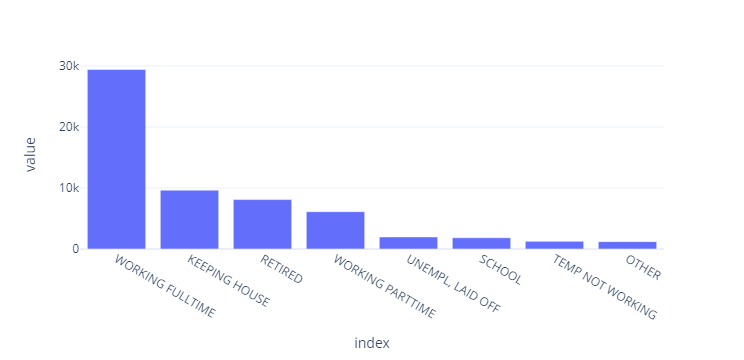

In [13]:
# Create a new figure object
fig = px.bar(df["labor_status"].value_counts(),
             template="plotly_white"
            )

# Hide the legend and show the plot
fig.update_layout(showlegend=False)
fig.show()

Good, but not great! It's often best to use a horizontal bar chart for categorical variables so the labels have room to breathe. Let's change the orientation of the plot and add a title.

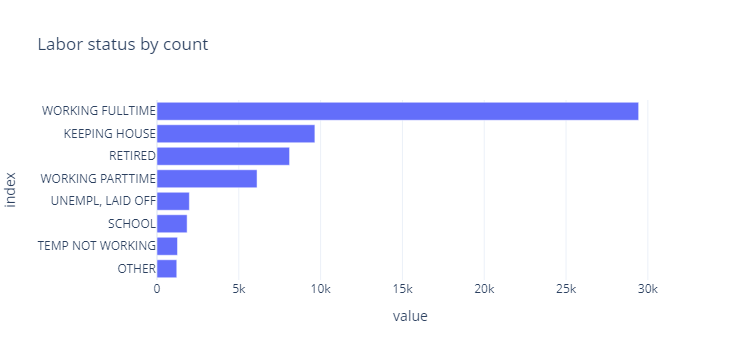

In [14]:
# Create a new figure object
fig = px.bar(df["labor_status"].value_counts(ascending=True),
             template="plotly_white",
             orientation="h",
             title="Labor status by count"
            )

# Hide the legend and show the plot
fig.update_layout(showlegend=False)
fig.show()

### Bar charts to show a categorical average
Besides counts, bar charts can be a great way to show aggregations of a categorical variable. Let's use our `decade` variable from earlier to visualize the average household size over time.

In [15]:
# Aggregate household size by year
household_by_decade = df.groupby("decade", as_index=False)["household_size"].mean()
household_by_decade

decade  household_size
0  1970s        3.234698
1  1980s        2.738080
2  1990s        2.543161
3  2000s        2.462987
4  2010s        2.410159

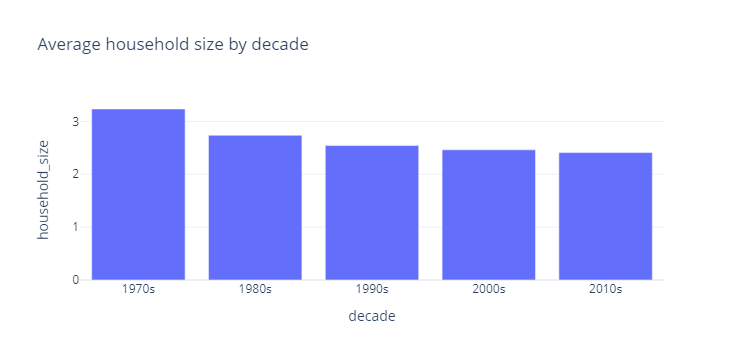

In [16]:
# Create a new figure object
fig = px.bar(household_by_decade,
             x="decade",
             y="household_size",
             template="plotly_white",
             title="Average household size by decade"
            )

fig.show()

### Boxplots
Boxplots display the median, quartiles, and range of a dataset in a way that allows for easy comparison between multiple groups or categories. The box in the plot represents the interquartile range (IQR), which contains the middle 50% of the data, with the median represented by a line inside the box. 

Here we use Plotly to create a [box plot](https://plotly.com/python/box-plots/) of the ages by employment. Do the distributions make sense per employment category?

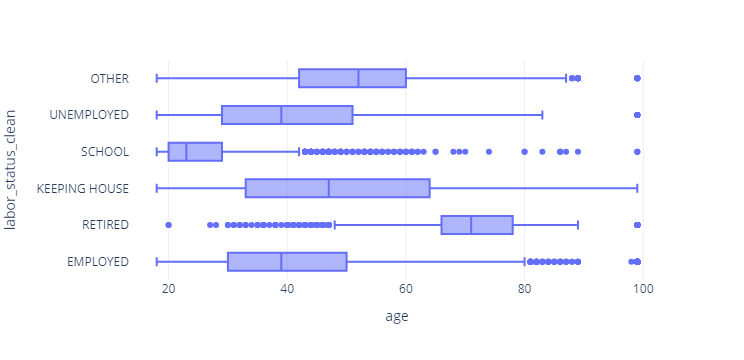

In [17]:
# Create a new figure object
fig = px.box(df,
             x="age",
             y="labor_status_clean",
             template="plotly_white"
            )

fig.show()

### Mosaic plots
Sometimes you will want to visualize the relationship between two categorical variables. One way to do this is a frequency table, which will give you the counts across the different combinations of the two variables.

You can create a frequency table using [`pd.crosstab()`](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html), and passing in your two columns.

In [18]:
pd.crosstab(df["degree_clean"], df["law_enforcement_clean"])

law_enforcement_clean  TOO LITTLE  ABOUT RIGHT  TOO MUCH
degree_clean                                            
HIGH SCHOOL                  8063         4879      1340
COLLEGE/UNIVERSITY           3230         2635       428

However, this can be hard to interpret, as it's not easy to get a sense of the proportions within the two categories. A better way to represent this data is a mosaic plot. Mosaic plots display the proportion of each category within each level of the other variable. This allows us to easily compare the distribution of the two variables. 

Mosaic plots are difficult to generate in Plotly, but fortunately `statsmodels` has a [`mosaic`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.mosaicplot.mosaic.html) function that makes generating them a breeze.

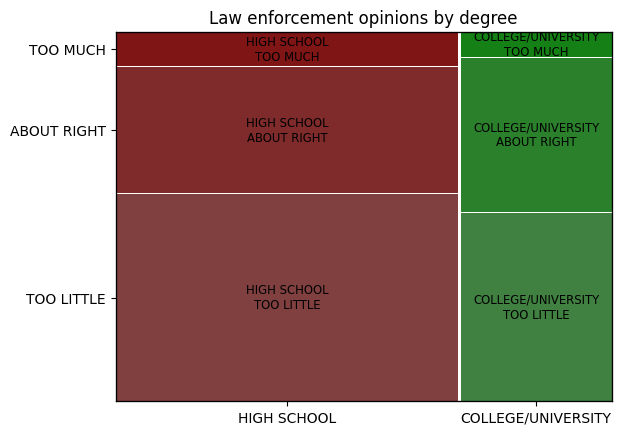

In [19]:
# Create a mosaic plot and show it
mosaic(df, 
       ['degree_clean', 'law_enforcement_clean'], 
       title='Law enforcement opinions by degree')

plt.show()

### Line charts
The final plot type we will cover is a line plot. Line plots often (but not always!) show the relationship between time and a numerical variable. Adding in a categorical variable can be a great way to enrich a line plot and provide other information.

Here, we use the `.value_counts()` method as an aggregation function, and use this in combination with a Plotly [`line_plot()`](https://plotly.com/python/line-charts/) to visualize the trend in marital statuses over the years.

In [20]:
# Group the dataframe by year and marital status, and calculate the normalized value counts
marital_rates = df.groupby(["year"], as_index=False)["marital_status"].value_counts(normalize=True)

# Display the resulting DataFrame
marital_rates

year marital_status  proportion
0    1972.0        MARRIED    0.719157
1    1972.0  NEVER MARRIED    0.130192
2    1972.0        WIDOWED    0.086175
3    1972.0       DIVORCED    0.040298
4    1972.0      SEPARATED    0.024179
..      ...            ...         ...
145  2014.0        MARRIED    0.456985
146  2014.0  NEVER MARRIED    0.266377
147  2014.0       DIVORCED    0.162194
148  2014.0        WIDOWED    0.082478
149  2014.0      SEPARATED    0.031965

[150 rows x 3 columns]

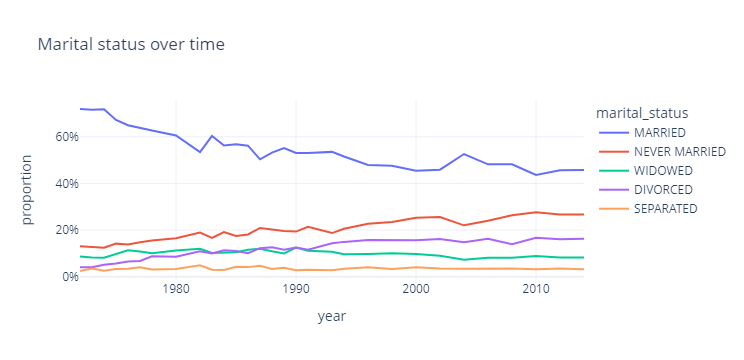

In [21]:
# Create a new figure object
fig = px.line(marital_rates,
              x="year",
              y="proportion",
              color="marital_status",
              template="plotly_white",
              title="Marital status over time"
             )

# Update the y-axis to show percentages
fig.update_yaxes(tickformat=".0%")

# Show the plot
fig.show()

## Next steps
To learn more techniques for working with categorical variables, check out [Working with Categorical Data in Python](https://app.datacamp.com/learn/courses/working-with-categorical-data-in-python). This course covers additional methods for working with categorical data, as well as advanced techniques like label and one-hot encoding.